## The goal is to create rolling one step forecast of crimes per month with ARIMA

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [37]:
alldata=pd.read_csv('full.csv')

In [38]:
alldata.head()

,COMPNOS,NatureCode,INCIDENT_TYPE_DESCRIPTION,MAIN_CRIMECODE,REPTDISTRICT,REPORTINGAREA,FROMDATE,WEAPONTYPE,Shooting,DOMESTIC,SHIFT,Year,Month,DAY_WEEK,UCRPART,X,Y,STREETNAME,XSTREETNAME,Location
0,120420285.0,BERPTA,RESIDENTIAL BURGLARY,05RB,D4,629,07/08/2012 06:00:00 AM,Other,No,No,Last,2012,7,Sunday,Part One,763273.1791,2951498.962,ABERDEEN ST,NaN,"(42.34638135, -71.10379454)"
1,120419202.0,PSHOT,AGGRAVATED ASSAULT,04xx,B2,327,07/08/2012 06:03:00 AM,Firearm,Yes,No,Last,2012,7,Sunday,Part One,771223.1638,2940772.099,HOWARD AV,NaN,"(42.31684135, -71.07458456)"
2,120419213.0,ARMROB,ROBBERY,03xx,D4,625,07/08/2012 06:26:00 AM,Firearm,No,No,Last,2012,7,Sunday,Part One,765118.8605,2950217.536,JERSEY ST,QUEENSBERRY ST,"(42.34284135, -71.09698955)"
3,120419223.0,ALARMC,COMMERCIAL BURGLARY,05CB,B2,258,07/08/2012 06:56:00 AM,Other,No,No,Last,2012,7,Sunday,Part One,773591.8648,2940638.174,COLUMBIA RD,NaN,"(42.3164411, -71.06582908)"
4,120419236.0,ARMROB,ROBBERY,03xx,E18,496,07/08/2012 07:15:00 AM,Firearm,No,No,Last,2012,7,Sunday,Part One,759042.7315,2923832.681,COLLINS ST,NaN,"(42.27051636, -71.11989955)"


In [39]:
alldata.shape

(268056, 20)

In [40]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268056 entries, 0 to 268055
Data columns (total 20 columns):
COMPNOS                      255797 non-null float64
NatureCode                   266391 non-null object
INCIDENT_TYPE_DESCRIPTION    268056 non-null object
MAIN_CRIMECODE               268056 non-null object
REPTDISTRICT                 267699 non-null object
REPORTINGAREA                268056 non-null int64
FROMDATE                     268056 non-null object
WEAPONTYPE                   268056 non-null object
Shooting                     268056 non-null object
DOMESTIC                     268056 non-null object
SHIFT                        255791 non-null object
Year                         268056 non-null int64
Month                        268056 non-null int64
DAY_WEEK                     268056 non-null object
UCRPART                      268056 non-null object
X                            253075 non-null float64
Y                            253075 non-null float64
STREE

Drop COMPNOS and UCRPART as these are internal BDP report number, not useful for analysis. Dropping XSTREETNAME as it has way to many missing data and is not crucial for analysis.

In [41]:
alldata=alldata.drop(['COMPNOS','XSTREETNAME','UCRPART'],axis=1)

Dropping all rows with missing values, there is still over 240k rows left, all of them with full data. Through this operation over 24k rows are deleted, which is a little over 9% of data I began with.

In [42]:
alldata=alldata.dropna()
alldata.shape

(243547, 17)

In [43]:
alldata['INCIDENT_TYPE_DESCRIPTION'].unique()

array(['RESIDENTIAL BURGLARY', 'AGGRAVATED ASSAULT', 'ROBBERY',
       'COMMERCIAL BURGLARY', 'SIMPLE ASSAULT', 'MedAssist', 'BENoProp',
       'VAL', 'FRAUD', 'PropFound', 'InvPer', 'TOWED', 'WEAPONS CHARGE',
       'InvProp', 'DRUG CHARGES', 'PersLoc', 'PropLost', 'OTHER LARCENY',
       'AUTO THEFT', 'Arrest', 'VANDALISM', 'MVAcc',
       'CRIMES AGAINST CHILDREN', 'PhoneCalls',
       'LARCENY FROM MOTOR VEHICLE', 'FIRE', 'Ballist', 'PubDrink',
       'Argue', 'Restrain', 'Gather', 'Service', 'SkipFare', 'SearchWarr',
       '32GUN', 'Harass', 'EMBEZELLMENT', 'OTHER', 'PRISON', 'FORGERY',
       'PersMiss', 'DEATH INVESTIGATION', 'LICViol', 'Landlord',
       'Hazardous', 'Plates', '07RV', 'PropDam', 'SexReg', 'HOMICIDE',
       'OPERATING UNDER INFLUENCE', 'STOLEN PROPERTY CHARGES', 'Runaway',
       'DISORDERLY', 'HateCrim', 'PROSTITUTION CHARGES', 'TRESPASS',
       'ARSON', 'BurgTools', 'Explos', 'VIOLATION OF LIQUOR LAWS',
       'Harbor', 'InvVeh', 'Bomb', 'Aircraft', 'Labor'

In [44]:
alldata['REPTDISTRICT'].unique()

array(['D4', 'B2', 'E18', 'C11', 'A1', 'D14', 'C6', 'E13', 'B3', 'A7',
       'A15', 'E5'], dtype=object)

All Boston PD districts are represented according to http://bpdnews.com/districts/

In [45]:
alldata['WEAPONTYPE'].unique()

array(['Other', 'Firearm', 'Unarmed', 'Knife'], dtype=object)

In [46]:
alldata['SHIFT'].unique()

array(['Last', 'Day', 'First'], dtype=object)

In [47]:
alldata['NatureCode'].unique()

array(['BERPTA', 'PSHOT ', 'ARMROB', 'ALARMC', 'SHOT  ', 'THREAT',
       'REQP  ', 'ALARMI', 'BEIP  ', 'IVMV  ', 'LARCRT', 'FDPROP',
       'ILLPRK', 'INVEST', 'INJOFF', 'INVCHD', 'IVDRUG', 'ARREST',
       'MVANO ', 'ABRPT ', 'BERPT ', 'MISPER', 'UNK   ', 'LSTPRP',
       'STOLMV', 'BURN1 ', 'IVPER ', 'VANRPT', 'FIGHT ', 'PDRPT ',
       'IVPREM', 'BEMVRT', 'DVIP  ', 'FIRE  ', 'OVRDOS', 'ABIP  ',
       'DOGRPT', 'CD99  ', 'NIDV  ', 'HARPT ', 'PERGUN', 'ALARMH',
       'MVPED1', 'HITRUN', 'STOLEN', 'VIORDR', 'MISCRP', 'MVPED2',
       'UNCONS', 'EDP2  ', 'CARST ', 'HOMINV', 'CD9   ', 'PKNIFE',
       'SHOTS ', 'MEET  ', 'MISC  ', 'ABDWRP', 'DISTRB', 'VANIP ',
       'ASTEMS', 'TSTOP ', 'MVA   ', 'TRANSP', 'CD11  ', 'LARCIP',
       'MVAINJ', 'SHPLFT', 'FIREB ', 'TRAUMA', 'SDNDTH', 'CD35  ',
       'IVLIC ', 'ROBRPT', 'ROBIP ', 'TRACK ', 'FDWEAP', 'CD19  ',
       'SSTOP ', 'ALARMX', 'ABDWIP', 'MVBLDR', 'STAB  ', 'MVARPT',
       'CRIP  ', 'TRESPS', 'MVACC ', 'AOD   ', 'MSNCOM', 'FDCH

In [48]:
print (alldata['MAIN_CRIMECODE'].unique())
print (len(alldata['MAIN_CRIMECODE'].unique()))

['05RB' '04xx' '03xx' '05CB' '08xx' 'MedAssist' 'BENoProp' 'VAL' '11xx'
 'PropFound' 'InvPer' 'TOWED' '15xx' 'InvProp' '18xx' 'PersLoc' 'PropLost'
 '06xx' '07xx' 'Arrest' '14xx' 'MVAcc' '20xx' 'PhoneCalls' '06MV' 'FIRE'
 'Ballist' 'PubDrink' 'Argue' 'Restrain' 'Gather' 'Service' 'SkipFare'
 'SearchWarr' '32GUN' 'Harass' '12xx' 'OTHER' 'PRISON' '10xx' 'PersMiss'
 '01INV' 'LICViol' 'Landlord' 'Hazardous' 'Plates' '07RV' 'PropDam'
 'SexReg' '01xx' '21xx' '13xx' 'Runaway' '24xx' 'HateCrim' '16xx'
 'TRESPASS' '09xx' 'BurgTools' 'Explos' '22xx' 'Harbor' 'InvVeh' 'Bomb'
 'Aircraft' 'Labor' 'Manslaug' '19xx' 'BioThreat']
69


With 77 possible outcomes the range of categories is too broad.

The remaining possibility is to create a binary category of a violent crime. The division would be the WEAPONTYPE - if the criminal is armed the crime is supposed to be violent.

In [49]:
alldata.loc[(alldata['WEAPONTYPE']=='Unarmed'),'VIOLENT']=0
alldata.loc[(alldata['WEAPONTYPE']!='Unarmed')&(alldata['WEAPONTYPE']!='Personal Weapon (hand  foot  etc.)'),'VIOLENT']=1

In [50]:
pd.crosstab(index=alldata['WEAPONTYPE'],columns='sum')

col_0,sum
WEAPONTYPE,
Firearm,4917
Knife,3713
Other,49895
Unarmed,185022


In [51]:
pd.crosstab(index=alldata['VIOLENT'],columns='sum')

col_0,sum
VIOLENT,
0.0,185022
1.0,58525


In [52]:
alldata['FROMDATEDAY'] = pd.to_datetime(alldata['FROMDATE'], format='%m/%d/%Y %I:%M:%S %p')
alldata.set_index('FROMDATEDAY', inplace=True)
alldata.sort_index(inplace=True)

In [53]:
alldata['DAY'] = alldata.index.day
alldata['HOUR'] = alldata.index.hour

Adding counter column to later count events by day

In [54]:
alldata['COUNT'] = 1

In [55]:
alldata.head()

,NatureCode,INCIDENT_TYPE_DESCRIPTION,MAIN_CRIMECODE,REPTDISTRICT,REPORTINGAREA,FROMDATE,WEAPONTYPE,Shooting,DOMESTIC,SHIFT,...,Month,DAY_WEEK,X,Y,STREETNAME,Location,VIOLENT,DAY,HOUR,COUNT
FROMDATEDAY,,,,,,,,,,,,,,,,,,,,,
2012-07-08 06:00:00,BERPTA,RESIDENTIAL BURGLARY,05RB,D4,629,07/08/2012 06:00:00 AM,Other,No,No,Last,...,7,Sunday,763273.1791,2951498.962,ABERDEEN ST,"(42.34638135, -71.10379454)",1.0,8,6,1
2012-07-08 06:03:00,PSHOT,AGGRAVATED ASSAULT,04xx,B2,327,07/08/2012 06:03:00 AM,Firearm,Yes,No,Last,...,7,Sunday,771223.1638,2940772.099,HOWARD AV,"(42.31684135, -71.07458456)",1.0,8,6,1
2012-07-08 06:26:00,ARMROB,ROBBERY,03xx,D4,625,07/08/2012 06:26:00 AM,Firearm,No,No,Last,...,7,Sunday,765118.8605,2950217.536,JERSEY ST,"(42.34284135, -71.09698955)",1.0,8,6,1
2012-07-08 06:56:00,ALARMC,COMMERCIAL BURGLARY,05CB,B2,258,07/08/2012 06:56:00 AM,Other,No,No,Last,...,7,Sunday,773591.8648,2940638.174,COLUMBIA RD,"(42.3164411, -71.06582908)",1.0,8,6,1
2012-07-08 07:15:00,ARMROB,ROBBERY,03xx,E18,496,07/08/2012 07:15:00 AM,Firearm,No,No,Last,...,7,Sunday,759042.7315,2923832.681,COLLINS ST,"(42.27051636, -71.11989955)",1.0,8,7,1


In [56]:
forecast=alldata['COUNT'].resample('M').count()
forecastV=alldata['VIOLENT'].resample('M').sum()
forecastV=forecastV.astype(int)

In [57]:
forecast=forecast.drop(forecast.index[0])
forecast=forecast.drop(forecast.index[len(forecast)-1])

In [58]:
forecastV=forecastV.drop(forecastV.index[len(forecastV)-1])
forecastV=forecastV.drop(forecastV.index[0])

Changed data to show monthly values and dropped first and last rows as they were not full months

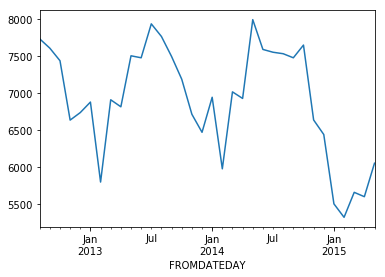

In [59]:
forecast.plot()
plt.show()

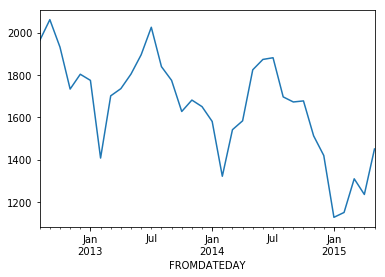

In [60]:
forecastV.plot()
plt.show()

Plots show that the data is not stationary but it can be also checked with ADF test.

Augmented Dickey-Fuller uses an autoregressive model and optimizes an information criterion across multiple different lag values.

Result is interpreted using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).

- p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [61]:
from statsmodels.tsa.stattools import adfuller

X = forecast.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.568792
p-value: 0.099620
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


In [62]:
from statsmodels.tsa.stattools import adfuller

XV = forecastV.values
result = adfuller(XV)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.062104
p-value: 0.260023
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


In both cases we can't reject null hypothesis as above 5% p-value. The data is non-stationary and needs to be transformed with ARIMA.

In [63]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

## Prediction of crime overall

In [64]:
forecast=forecast.astype(float)

In [65]:
X = forecast.values
train, test = X[0:-12], X[-12:]

In [66]:
print(forecast.index)

DatetimeIndex(['2012-08-31', '2012-09-30', '2012-10-31', '2012-11-30',
               '2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31',
               '2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31',
               '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30',
               '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31',
               '2014-04-30', '2014-05-31', '2014-06-30', '2014-07-31',
               '2014-08-31', '2014-09-30', '2014-10-31', '2014-11-30',
               '2014-12-31', '2015-01-31', '2015-02-28', '2015-03-31',
               '2015-04-30', '2015-05-31'],
              dtype='datetime64[ns]', name='FROMDATEDAY', freq='M')


In [67]:
rng1 = pd.date_range('2012-07-31', periods=len(X)-12, freq='M').shift(1, freq=pd.datetools.day)
rng2 =pd.date_range('2014-05-30', periods=12, freq='M').shift(1, freq=pd.datetools.day)
print(rng1)
print(rng2)

DatetimeIndex(['2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01'],
              dtype='datetime64[ns]', freq='MS')
DatetimeIndex(['2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
               '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
               '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01'],
              dtype='datetime64[ns]', freq='MS')


In [68]:
trainS=pd.Series(train, index=rng1)
testS=pd.Series(test,index=rng2)

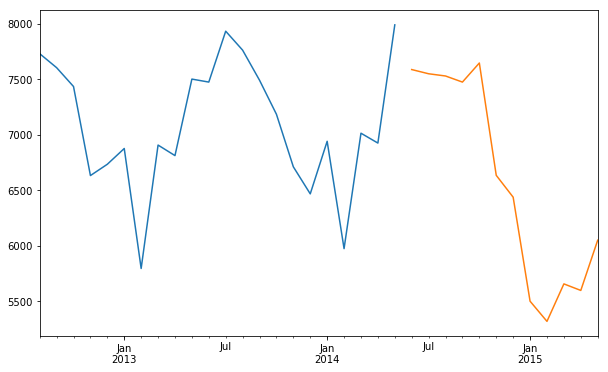

In [69]:
plt.figure(figsize=(10,6));
trainS.plot()
testS.plot()
plt.show()

## ARIMA parameters cross validation

In [70]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [73]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(forecast.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1005455.464
ARIMA(0, 0, 1) MSE=591258.895
ARIMA(0, 0, 2) MSE=332932.411
ARIMA(0, 1, 0) MSE=208729.254
ARIMA(0, 1, 1) MSE=224702.400
ARIMA(0, 1, 2) MSE=324836.954
ARIMA(0, 2, 0) MSE=545900.936
ARIMA(0, 2, 1) MSE=268821.510
ARIMA(1, 0, 0) MSE=307706.266
ARIMA(1, 1, 0) MSE=234965.510
ARIMA(1, 1, 1) MSE=229884.579
ARIMA(1, 2, 0) MSE=308235.603
ARIMA(1, 2, 1) MSE=350110.988
ARIMA(2, 0, 0) MSE=307808.214
ARIMA(2, 1, 0) MSE=221118.214
ARIMA(2, 1, 1) MSE=225197.644
ARIMA(2, 2, 0) MSE=344054.875
ARIMA(2, 2, 1) MSE=367225.967
ARIMA(4, 0, 0) MSE=282863.201
ARIMA(4, 1, 0) MSE=196071.264
ARIMA(4, 2, 0) MSE=418832.083
ARIMA(6, 1, 0) MSE=356562.817
ARIMA(6, 2, 0) MSE=466971.289
Best ARIMA(4, 1, 0) MSE=196071.264


## Prediction using best parameters

Test RMSE: 442.794


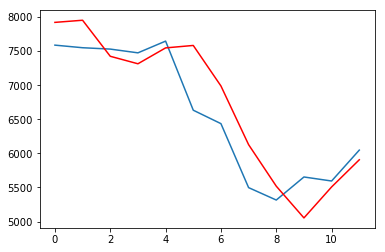

In [74]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    # fit model
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    # one step forecast
    yhat = model_fit.forecast()[0]
    # store forecast and ob
    predictions.append(yhat)
    history.append(test[t])
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

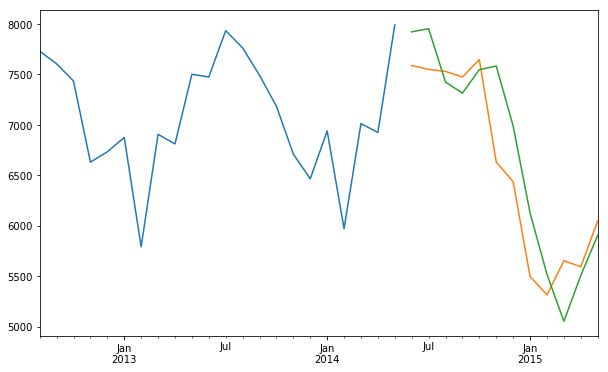

In [75]:
pre=pd.Series(np.stack(predictions,1)[0], index=testS.index)

plt.figure(figsize=(10,6));
trainS.plot()
testS.plot()
pre.plot()
plt.show()

In [76]:
predictions

[array([ 7920.66530153]),
 array([ 7951.92844769]),
 array([ 7423.58729897]),
 array([ 7313.76676257]),
 array([ 7546.51133627]),
 array([ 7582.36574104]),
 array([ 6988.48501968]),
 array([ 6127.95383619]),
 array([ 5519.1763724]),
 array([ 5053.90141459]),
 array([ 5508.16596372]),
 array([ 5906.18835247])]

## Prediction of violent crime

In [77]:
forecastV=forecastV.astype(float)
X = forecastV.values
train, test = X[0:-12], X[-12:]                         

In [78]:
print(forecast.index)
rng1 = pd.date_range('2012-07-31', periods=len(X)-12, freq='M').shift(1, freq=pd.datetools.day)
rng2 =pd.date_range('2014-05-30', periods=12, freq='M').shift(1, freq=pd.datetools.day)
print(rng1)
print(rng2)

DatetimeIndex(['2012-08-31', '2012-09-30', '2012-10-31', '2012-11-30',
               '2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31',
               '2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31',
               '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30',
               '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31',
               '2014-04-30', '2014-05-31', '2014-06-30', '2014-07-31',
               '2014-08-31', '2014-09-30', '2014-10-31', '2014-11-30',
               '2014-12-31', '2015-01-31', '2015-02-28', '2015-03-31',
               '2015-04-30', '2015-05-31'],
              dtype='datetime64[ns]', name='FROMDATEDAY', freq='M')
DatetimeIndex(['2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-0

In [79]:
trainS=pd.Series(train, index=rng1)
testS=pd.Series(test,index=rng2)

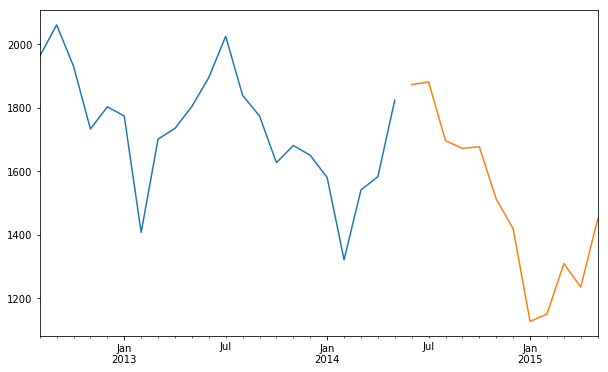

In [80]:
plt.figure(figsize=(10,6));
trainS.plot()
testS.plot()
plt.show()

## Prediction of violent crime

Test RMSE: 151.645


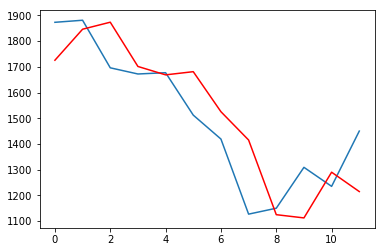

In [81]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    # fit model
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    # one step forecast
    yhat = model_fit.forecast()[0]
    # store forecast and ob
    predictions.append(yhat)
    history.append(test[t])
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

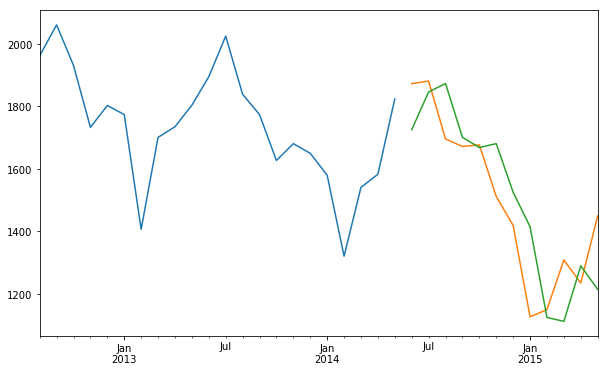

In [82]:
pre=pd.Series(np.stack(predictions,1)[0], index=testS.index)

plt.figure(figsize=(10,6));
trainS.plot()
testS.plot()
pre.plot()
plt.show()

In [83]:
predictions

[array([ 1725.48965384]),
 array([ 1846.1414135]),
 array([ 1873.38880096]),
 array([ 1701.24960472]),
 array([ 1668.61096543]),
 array([ 1680.98032837]),
 array([ 1525.30011557]),
 array([ 1415.17397542]),
 array([ 1124.87191738]),
 array([ 1112.29255266]),
 array([ 1290.04763778]),
 array([ 1214.76529613])]